In [2]:
import pdfplumber
import re
import pandas as pd
import os
from datetime import datetime

from dataclasses import dataclass
from typing import List, Dict, Optional
from pypdf import PdfReader
%pip install matplotlib pandas


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
@dataclass
class GastEintrag:
    namen: List[str]      
    beschreibung: str

In [4]:
def build_text_list_from_pdf(pdf_path): 
    
    reader = PdfReader(pdf_path)
    episodes = []
    current_episode_parts = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text = page.extract_text()
            if not text:
                continue

            matches = re.findall(r"Seite\s+(\d+)\s+von\s+(\d+)", text)

            if matches:
                # Wir nehmen das letzte Vorkommen auf der Seite, da es sich meist um die Fußzeile handelt
                current_page_num, total_pages = map(int, matches[-1])

                if current_page_num == 1:
                        # Neue Episode beginnt
                        current_episode_parts = [text]
                else:
                    # Fortsetzung einer Episode
                    current_episode_parts.append(text)

                        
                if current_page_num == total_pages:
                    # Text zusammenfügen und zur Ergebnisliste hinzufügen
                    full_text = "\n".join(current_episode_parts)
                    episodes.append(full_text)
                    current_episode_parts = [] # Puffer zurücksetzen

    return episodes

In [5]:
def text_files(episodes, path):
    """
    Speichert die Liste der Episoden in eine einzelne Textdatei.
    
    Args:
        episodes (list): Die Liste mit den Episodentexten.
        filename (str): Der Name der Zieldatei.
    """
    # 'utf-8' ist wichtig für Umlaute (ä, ö, ü) und Sonderzeichen
    with open(path, "w", encoding="utf-8") as f:
        for i, episode in enumerate(episodes, 1):
            # Eine Überschrift pro Episode schreiben
            f.write(f"--- EPISODE {i} ---\n\n")
            
            # Den eigentlichen Text schreiben
            f.write(episode)
            
            # Trennlinie für bessere Lesbarkeit am Ende jeder Episode
            f.write("\n\n" + "="*50 + "\n\n")

    print(f"Erfolgreich gespeichert in: {path}")

In [6]:
def clean_episodes(episodes):
    cleaned_episodes = []

    # Einfacher Schalter: Haben wir die Folge schon gesehen?
    hatte_15_12_schon = False
    hatte_12_11_schon = False 

    scheller_pattern = r"Scheller,.*?ZDF P r o g r a m m - D a t e n b a n k"
    page_pattern = r"TV Seite\s+\d+\s+von\s+\d+"

    for text in episodes:
        
        # --- SPEZIAL-CHECK FÜR Duplikate ---
        if "Markus Lanz 15.12.2015" in text:
            if hatte_15_12_schon:
                # Wenn wir sie schon einmal hatten (True), ist das hier das Duplikat -> Rauslöschen (continue)
                print("Found Duplicate: Markus Lanz 15.12.2015")
                continue
            else:
                # Das erste Mal gefunden -> Schalter umlegen und behalten
                hatte_15_12_schon = True


        if "Markus Lanz 12.11.2015" in text: 
            if hatte_12_11_schon:
                print("Found Duplicate: Markus Lanz 12.11.2015")
                # Wenn wir sie schon einmal hatten (True), ist das hier das Duplikat -> Rauslöschen (continue)
                continue
            else:
                # Das erste Mal gefunden -> Schalter umlegen und behalten
                hatte_12_11_schon = True


        # 1. Den Scheller-Block entfernen
        text = re.sub(scheller_pattern, "", text, flags=re.DOTALL | re.IGNORECASE)
        
        # 2. Die Seitenzahlen entfernen
        text = re.sub(page_pattern, "", text, flags=re.IGNORECASE)
        
        # 3. Kosmetik
        text = re.sub(r'\n{3,}', '\n\n', text)
        
        cleaned_episodes.append(text.strip())
        
    return cleaned_episodes

In [7]:
def extrahiere_sendungs_details(text: str) -> Dict[str, Optional[str]]:
    """
    Extrahiert Datum, Sendezeit-Range und Dauer aus dem rohen Textblock.
    """
    daten = {
        "Titel": None,
        "Datum": None,
        "Sendezeit": None,
        "Dauer": None,
        "FolgenNr": None,
        "Staffel": None, 
        "Folge": None,
        "Information": None
    }

    match_folgen_nr = re.search(r"FolgenNr\s+(\d+)", text)
    if match_folgen_nr:
        daten["FolgenNr"] = match_folgen_nr.group(1)
    else: 
        daten["FolgenNr"] = None

    match_staffel = re.search(r"Staffel\s+(\d+)", text)
    if match_staffel:
        daten["Staffel"] = match_staffel.group(1)
    else:
        daten["Staffel"] = None

    match_folge = re.search(r"Folge\s+(\d+)", text)
    if match_folge:
        daten["Folge"] = match_folge.group(1)
    else:
        daten["Folge"] = None


    # 1. Datum suchen (Nach dem Keyword "Publikation")
    if "Publikation" in text:
        # Wir nehmen alles nach "Publikation"
        part_publikation = text.split("Publikation", 1)[1]
        
        # Regex für Datum (DD.MM.YYYY)
        # Wir suchen das ERSTE Datum, das nach Publikation auftaucht
        date_match = re.search(r"(\d{2}\.\d{2}\.\d{4})", part_publikation)
        if date_match:
            daten["Datum"] = date_match.group(1)

    # 2. Sendezeit und Dauer suchen (Nach dem Keyword "Sachinhalt")
    # Das Format ist dort meist: "Sachinhalt HH:MM:SS - HH:MM:SS MMM'SS"
    if "Sachinhalt" in text:
        part_sachinhalt = text.split("Sachinhalt", 1)[1]
        
        # Regex Erklärung:
        # (\d{2}:\d{2}:\d{2}\s*-\s*\d{2}:\d{2}:\d{2}) -> Gruppe 1: Zeit von - bis
        # \s+                                         -> Leerzeichen
        # (\d{2,3}'\d{2})                             -> Gruppe 2: Dauer (z.B. 67'41 oder 067'41)
        
        zeit_pattern = r"(\d{2}:\d{2}:\d{2}\s*-\s*\d{2}:\d{2}:\d{2})\s+(\d{2,3}'\d{2})"
        
        zeit_match = re.search(zeit_pattern, part_sachinhalt)
        if zeit_match:
            daten["Sendezeit"] = zeit_match.group(1)
            daten["Dauer"] = zeit_match.group(2)

    # Information zwischen "Sachinhalt" und "Jugendeignung" extrahieren
    match = re.search(r"Sachinhalt(.*?)Jugendeignung", text, re.DOTALL)
    if match:
        daten["Information"] = match.group(1).strip().replace("\n", " ")

    #Titel extrahieren
    keyword = 'Sendetitel'

    if keyword not in text:
        daten["titel"] = "Unbekannt (Kein 'Sendetitel' gefunden)"

    parts = text.split(keyword, 1)

    # 3. Prüfen, ob der Split erfolgreich war (Liste muss mind. 2 Teile haben)
    if len(parts) < 2:
        daten["titel"] =  "Unbekannt (Split fehlgeschlagen)"

    raw_title_part = parts[1]

    title = raw_title_part.split('\n', 1)[0]

    daten["Titel"] = title 

    return daten

In [8]:
def extract_guests(text: str) -> List[GastEintrag]:
    ergebnisse = []


    keywords = ["Studiogästen", "Studiogast"]
    
    relevant_part = text  # Fallback: Ganzer Text, falls kein Keyword gefunden wird

    for kw in keywords:
        if kw in text:
            # Wir splitten beim ersten gefundenen Keyword und nehmen den Teil danach
            relevant_part = text.split(kw, 1)[1]

    blöcke = re.finditer(r'([^)]+)\(([^)]+)\)', relevant_part)

    for match in blöcke:
        namen_roh = match.group(1).strip()
        beschreibung = match.group(2).strip()
        
        # Wir ignorieren Satzzeichen am Ende des Namensblocks (z.B. Kommas vom vorherigen Eintrag)
        if namen_roh.startswith(","):
            namen_roh = namen_roh[1:].strip()

        # Namen aus dem Roh-String extrahieren
        # Muster: Wort (TitleCase) + optional Mittelname/Initial + WORT (UPPERCASE)
        # \b           -> Wortgrenze
        # [A-ZÄÖÜ][a-zäöü]+ -> Vorname (Großbuchstabe gefolgt von Kleinbuchstaben)
        # (?: ... )* -> Optionale Mittelnamen oder Initialen (z.B. "Philip D" oder "Hans Peter")
        # \s+          -> Leerzeichen
        # [A-ZÄÖÜß]+   -> NACHNAME (Nur Großbuchstaben, mind. 2 Zeichen um "I" vs "IN" zu unterscheiden, oder einfach +)
        
        name_pattern = r'\b[A-ZÄÖÜ][a-zäöü]+(?:\s+(?:[A-Z]\.?|[A-ZÄÖÜ][a-zäöü]+))*\s+[A-ZÄÖÜß]+(?:-[A-ZÄÖÜß]+)?'
        
        gefundenen_namen = re.findall(name_pattern, namen_roh)

        if gefundenen_namen:
            eintrag = GastEintrag(
                namen=gefundenen_namen,
                beschreibung=beschreibung
            )
            ergebnisse.append(eintrag)

    return ergebnisse

In [9]:
def extract_persons(episodes):
    """
    Extrahiert Gäste und gruppiert sie pro Person.
    Ausgabe: Eine Zeile pro Gast.
    - Alle Beschreibungen werden gesammelt und kommagetrennt.
    - Alle Auftritte werden als eigene Spalten angefügt.
    """

    guest_map = {}

    for episode_text in episodes:
        if not episode_text:
            continue

        # 1. Daten extrahieren
        daten = extrahiere_sendungs_details(episode_text)

        if "Sachinhalt" not in episode_text:
            continue

        text_flat = episode_text.replace('\n', ' ').replace('\r', '')

        try:
            content_part = text_flat.split("Sachinhalt", 1)[1]
        except IndexError:
            continue

        # Keywords zum Abschneiden
        keywords = [';', 'über', 'Themen', 'Thema', 'Themen:', 'Thema:', 'Jugendeignung', 'Schwerpunktthemen:', 'Schwerpunktthemen', 'Scherpunktthemen:']
        keywords.sort(key=len, reverse=True)
        pattern_split = "|".join(map(re.escape, keywords))
        
        guests_section = re.split(pattern_split, content_part, maxsplit=1)[0]

        # Regex ausführen
        gefundene_eintraege = extract_guests(guests_section)
        
        # Datum parsen
        try:
            datum_sort = pd.to_datetime(daten["Datum"], format="%d.%m.%Y", errors="coerce")
        except:
            datum_sort = pd.NaT

        for eintrag in gefundene_eintraege:
            for einzelner_name in eintrag.namen:
                name_clean = einzelner_name.strip()
                
                # Wenn Gast noch nicht bekannt, neu anlegen
                if name_clean not in guest_map:
                    guest_map[name_clean] = {
                        "descriptions": set(), # Set für eindeutige Beschreibungen
                        "appearances": [] 
                    }
                
                # Beschreibung hinzufügen (wenn vorhanden)
                if eintrag.beschreibung:
                    clean_desc = eintrag.beschreibung.strip()
                    if clean_desc: # Nur nicht-leere Beschreibungen
                        guest_map[name_clean]["descriptions"].add(clean_desc)

                # Auftritt hinzufügen
                guest_map[name_clean]["appearances"].append((datum_sort, daten['Titel']))

    # --- DATAFRAME ERSTELLEN ---
    
    final_rows = []
    
    for name, info in guest_map.items():
        
        # 1. Auftritte sortieren
        sorted_apps = sorted(info["appearances"], key=lambda x: (x[0] is pd.NaT, x[0]))
        app_strings = [app[1] for app in sorted_apps]
        
        # 2. Beschreibungen zusammenfügen
        # Wir sortieren die Liste, damit die Reihenfolge deterministisch ist
        # und joinen sie mit Komma und Leerzeichen
        combined_description = ", ".join(sorted(list(info["descriptions"])))
        
        row = {
            "Name": name,
            "Beschreibung": combined_description, # Alle Beschreibungen hier
            "Anzahl_Auftritte": len(app_strings)
        }
        
        # Dynamisch Spalten "Public Appearance X" füllen
        for idx, app_str in enumerate(app_strings, start=1):
            row[f"Public Appearance {idx}"] = app_str
            
        final_rows.append(row)

    df = pd.DataFrame(final_rows)

    if not df.empty:
        df = df.sort_values(by="Name")
        
        # Spalten ordnen
        cols = list(df.columns)
        base_cols = ["Name", "Beschreibung", "Anzahl_Auftritte"]
        appearance_cols = [c for c in cols if c.startswith("Public Appearance")]
        
        # Appearance Spalten numerisch korrekt sortieren (1, 2, ... 10)
        appearance_cols.sort(key=lambda x: int(x.split(" ")[-1]))
        
        # Zusammenfügen, dabei sicherstellen, dass nur existierende Spalten genutzt werden
        final_cols = base_cols + appearance_cols
        df = df[final_cols]

    return df

In [10]:
def extract_episodes(episodes):
    """
    Erstellt einen DataFrame mit einer Zeile pro Episode.
    Enthält Metadaten, dynamische Spalten für Gäste und eine berechnete Season-Spalte.
    """

    alle_daten = []

    for episode_text in episodes:
        if not episode_text:
            continue

        daten = extrahiere_sendungs_details(episode_text)

        if "Sachinhalt" not in episode_text:
            continue

        text_flat = episode_text.replace('\n', ' ').replace('\r', '')

        try:
            content_part = text_flat.split("Sachinhalt", 1)[1]
        except IndexError:
            continue

        keywords = [';', 'über', 'Themen', 'Thema', 'Themen:', 'Thema:', 'Jugendeignung', 'Schwerpunktthemen:', 'Schwerpunktthemen', 'Scherpunktthemen:']
        keywords.sort(key=len, reverse=True)
        
        pattern_split = "|".join(map(re.escape, keywords))
        guests_section = re.split(pattern_split, content_part, maxsplit=1)[0]

        gefundene_eintraege = extract_guests(guests_section)
        
        zeilen_daten = {
            "Sendungstitel": daten.get("Titel"),
            "Staffel": daten.get("Staffel"),
            "Folge": daten.get("Folge"),
            "FolgenNr": daten.get("FolgenNr"),
            "Publikationsdatum": daten.get("Datum"),
            "Dauer": daten.get("Dauer"),
            "Infos": daten.get("Information")
        }
        
        gast_counter = 1
        for eintrag in gefundene_eintraege:
            for einzelner_name in eintrag.namen:
                key = f"Gast_{gast_counter}"
                zeilen_daten[key] = einzelner_name
                gast_counter += 1

        alle_daten.append(zeilen_daten)

    # --- DataFrame erstellen ---
    df = pd.DataFrame(alle_daten)


    # Datums-Hilfsspalte erstellen (wichtig für Sortierung UND Staffel-Berechnung)
    # Wir nutzen 'coerce', damit Fehler NaT ergeben, statt das Skript crashen zu lassen
    df["Datum_Sortierbar"] = pd.to_datetime(df["Publikationsdatum"], format="%d.%m.%Y", errors="coerce")

    # --- Logik für die "season" Spalte ---
    def get_season_string(row):
        existing_staffel = row.get("Staffel")
        titel = str(row.get("Sendungstitel", ""))
        datum_obj = row.get("Datum_Sortierbar")

        # Fall 1: Staffel ist bereits vorhanden
        if pd.notna(existing_staffel) and str(existing_staffel).strip():
            return f"Markus Lanz, Staffel {existing_staffel}"
        
        # Fall 2: Staffel fehlt -> Prüfen ob Titel das Standard-Format hat
        # Regex prüft auf exakt "Markus Lanz DD.MM.YYYY" (D=Ziffer)
        
        if re.match(r"^Markus Lanz \d{2}\.\d{2}\.\d{4}$", titel):
            calc_staffel = datum_obj.year - 2007
            return f"Markus Lanz, Staffel {calc_staffel}"
                
        # Fall 3: Weder Staffel vorhanden noch Titel-Format passend -> Leer
        return ""

    df['Sendungstitel'] = df['Sendungstitel'].str.strip()
    # Die Funktion auf jede Zeile anwenden
    df["season"] = df.apply(get_season_string, axis=1)
    # ------------------------------------------

    # Sortierung logisch nach Datum
    df = df.sort_values(by="Datum_Sortierbar", ascending=True)
    
    # Aufräumen: Hilfsspalte löschen
    df = df.drop(columns=["Datum_Sortierbar"])
        
    # Spalten sortieren
    cols = list(df.columns)
    meta_cols = ["Sendungstitel", "season", "Staffel", "Folge", "FolgenNr", "Publikationsdatum", "Dauer", "Infos"] # season nach vorne geholt
    gast_cols = [c for c in cols if c.startswith("Gast_")]
    gast_cols.sort(key=lambda x: int(x.split("_")[1]))
    
    rest_cols = [c for c in cols if c not in meta_cols and c not in gast_cols]
    
    final_order = meta_cols + rest_cols + gast_cols
    final_order = [c for c in final_order if c in df.columns]
    
    df = df[final_order]

    # Wikidata Metadaten
    df["instance_of"] = 'Q21191270'
    df["part_of_series"] = 'Q1499182'
    df["genre"] = 'Q622812'
    df["presenter"] = 'Q43773'
    df["original_broadcaster"] = 'Q48989'
    df["country_of_origin"] = 'Q183'
    df["original_language_of_film_or_TV_show"] = 'Q188'
    
    return df

In [11]:
def extract_seasons(episodes):
    """
    Erstellt eine Übersicht der Staffeln basierend auf Jahren.
    Staffel 1 beginnt 2008.
    """
    
    # Zwischenspeicher: Key = Jahr, Value = Liste von Datum-Objekten
    # Beispiel: { 2018: [datetime(2018,1,5), datetime(2018,1,6)...] }
    years_data = {}

    # Regex für das strikte Titelformat: "Markus Lanz DD.MM.YYYY"
    regex_title_strict = re.compile(r"Markus Lanz \s*\d{2}\.\d{2}\.\d{4}")
    
    # Regex um das Datum generell zu finden (dd.mm.yyyy)
    regex_date = re.compile(r"(\d{2}\.\d{2}\.\d{4})")

    for episode_text in episodes:
        if not episode_text:
            continue
            
        # 1. Relevante Zeilen finden
        # Wir suchen die Zeile, die mit "Sendetitel" beginnt, um das Format zu prüfen
        lines = episode_text.splitlines()
        title_line = ""
        for line in lines:
            if line.strip().startswith("Sendetitel"):
                title_line = line.strip()
                break
        
        # Falls kein Sendetitel gefunden wurde, suchen wir im ganzen Text nach dem Datum
        # (Fallback, falls Formatierung abweicht)
        search_text = title_line if title_line else episode_text

        # 2. Prüfen, ob Episode berücksichtigt werden soll
        # Bedingung A: Titel hat Format "Markus Lanz DD.MM.YYYY"
        condition_a = bool(regex_title_strict.search(title_line))
        
        # Bedingung B: Es gibt einen "Staffel" Eintrag im Text
        condition_b = "Staffel" in episode_text
        
        if not (condition_a or condition_b):
            continue

        # 3. Datum extrahieren
        # Wir bevorzugen das Datum aus dem Titel, sonst das erste Datum im Text
        date_match = regex_date.search(title_line)
        if not date_match:
            # Fallback: Suche erstes Datum im gesamten Block (z.B. bei Info Sendedatum)
            date_match = regex_date.search(episode_text)
            
        if date_match:
            date_str = date_match.group(1)
            try:
                dt_obj = pd.to_datetime(date_str, format="%d.%m.%Y")
                year = dt_obj.year
                
                if year not in years_data:
                    years_data[year] = []
                years_data[year].append(dt_obj)
            except ValueError:
                continue

    # 4. DataFrame aus den gesammelten Daten bauen
    season_rows = []
    
    # Sortierte Jahre durchgehen
    for year in sorted(years_data.keys()):
        dates = years_data[year]
        
        # Metriken berechnen
        start_date = min(dates)
        end_date = max(dates)
        count = len(dates)
        
        # Staffelnummer berechnen (2008 -> 1, 2009 -> 2, etc.)
        season_num = year - 2007
        season_name = f"Markus Lanz, Staffel {season_num}"
        
        season_rows.append({
            "Staffel Name": season_name,
            "start_time": start_date, 
            "end_time": end_date,
            "Anzahl an Folgen": count
        })

    df = pd.DataFrame(season_rows)
    
    # Formatierung der Datumsspalten als String (DD.MM.YYYY) für schönere Ausgabe
    if not df.empty:
        df["start_time"] = df["start_time"].dt.strftime("%d.%m.%Y")
        df["end_time"] = df["end_time"].dt.strftime("%d.%m.%Y")


    df["instance_of"] = 'Q3464665'
    df["part_of_series"] = 'Q1499182'
    df["genre"] = 'Q622812'
    df["presenter"] = 'Q43773'
    df["original_broadcaster"] = 'Q48989'
    df["country_of_origin"] = 'Q183'
    df["original_language_of_film_or_TV_show"] = 'Q188'

    return df

In [12]:
pdf_names = ['Markus Lanz_2008-2010.pdf', 'Markus Lanz_2011-2015.pdf', 'Markus Lanz_2016-2020.pdf', 'Markus Lanz_2021-2024.pdf']

episode_strings = []

for pdf_name in pdf_names:
    path = f"ZDF_Archiv/{pdf_name}"
    if os.path.exists(path):
        try:
            print(f"Starte Extraktion von {pdf_name}...")
            episodes_from_pdf = build_text_list_from_pdf(path)
            #text_files(episodes, filename=f"textfiles/{pdf_name}_episodes.txt")
            for episode in reversed(episodes_from_pdf): 
                episode_strings.append(episode)
            print(f"{len(episodes_from_pdf)} Folgen in {pdf_name} gefunden")
        except Exception as e:
            print(f"Kritischer Fehler: {e}")
    else:
        print(f"Datei '{path}' nicht im Ordner gefunden.")

Starte Extraktion von Markus Lanz_2008-2010.pdf...
179 Folgen in Markus Lanz_2008-2010.pdf gefunden
Starte Extraktion von Markus Lanz_2011-2015.pdf...
638 Folgen in Markus Lanz_2011-2015.pdf gefunden
Starte Extraktion von Markus Lanz_2016-2020.pdf...
666 Folgen in Markus Lanz_2016-2020.pdf gefunden
Starte Extraktion von Markus Lanz_2021-2024.pdf...
555 Folgen in Markus Lanz_2021-2024.pdf gefunden


In [13]:
episode_strings = clean_episodes(episode_strings)

print(f"Episodes found: {len(episode_strings)}")


persondf = extract_persons(episode_strings)
persondf.to_csv(f"person/Personen.csv", index=False)

episodesdf = extract_episodes(episode_strings)
duplicates =    episodesdf[
                episodesdf['FolgenNr'].notna() &
                episodesdf.duplicated(subset=['FolgenNr'], keep=False)
]
print(duplicates.to_string())

episodesdf.to_csv(f"episodes/Episoden.csv", index=False)

seasonsdf = extract_seasons(episode_strings)
seasonsdf.to_csv(f"seasons/Staffeln.csv", index=False)



Found Duplicate: Markus Lanz 12.11.2015
Found Duplicate: Markus Lanz 15.12.2015
Episodes found: 2036
              Sendungstitel                  season Staffel Folge FolgenNr Publikationsdatum   Dauer                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [14]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


EpisodesPerWeekDf = pd.read_csv("SPARQL-Results/EpisodeDates.csv")

EpisodesPerWeekDf['datum'] = pd.to_datetime(EpisodesPerWeekDf['date'])

wochen_counts = EpisodesPerWeekDf.set_index('datum').resample('W').size()

durchschnitt = wochen_counts.mean()

haeufigkeits_verteilung = wochen_counts.value_counts().sort_index()

print("\nVerteilung der Ausstrahlungen pro Woche:")
print(haeufigkeits_verteilung)

print()
print(f"Anzahl pro Woche:\n{wochen_counts.to_string()}")
print(f"\nDurchschnitt pro Woche: {durchschnitt}")



Verteilung der Ausstrahlungen pro Woche:
0    144
1     18
2     94
3    603
4      5
Name: count, dtype: int64

Anzahl pro Woche:
datum
2008-06-08 00:00:00+00:00    3
2008-06-15 00:00:00+00:00    1
2008-06-22 00:00:00+00:00    2
2008-06-29 00:00:00+00:00    2
2008-07-06 00:00:00+00:00    2
2008-07-13 00:00:00+00:00    2
2008-07-20 00:00:00+00:00    2
2008-07-27 00:00:00+00:00    2
2008-08-03 00:00:00+00:00    2
2008-08-10 00:00:00+00:00    2
2008-08-17 00:00:00+00:00    2
2008-08-24 00:00:00+00:00    2
2008-08-31 00:00:00+00:00    2
2008-09-07 00:00:00+00:00    3
2008-09-14 00:00:00+00:00    0
2008-09-21 00:00:00+00:00    0
2008-09-28 00:00:00+00:00    0
2008-10-05 00:00:00+00:00    0
2008-10-12 00:00:00+00:00    0
2008-10-19 00:00:00+00:00    0
2008-10-26 00:00:00+00:00    0
2008-11-02 00:00:00+00:00    0
2008-11-09 00:00:00+00:00    0
2008-11-16 00:00:00+00:00    0
2008-11-23 00:00:00+00:00    0
2008-11-30 00:00:00+00:00    0
2008-12-07 00:00:00+00:00    0
2008-12-14 00:00:00+00:00

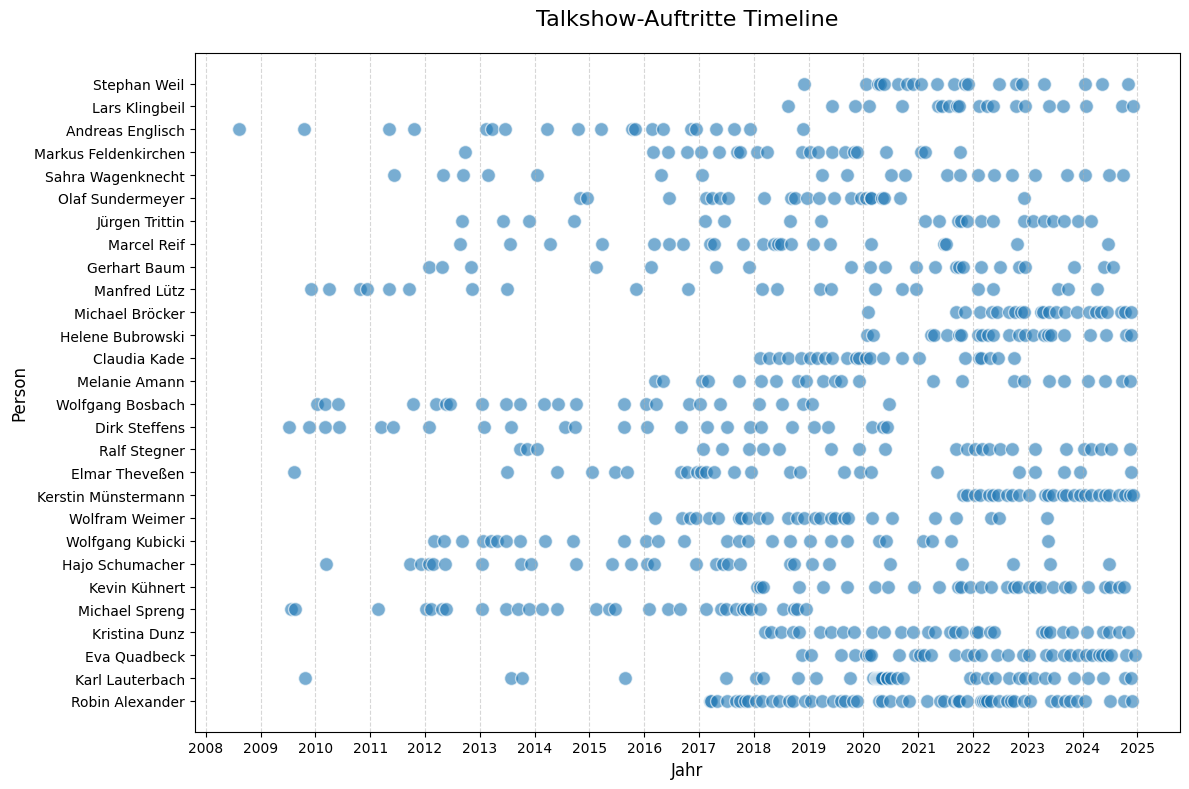

In [15]:
GuestTimeLineDf = pd.read_csv('SPARQL-Results/Gastauftritte20mal.csv')
GuestTimeLineDf['date'] = pd.to_datetime(GuestTimeLineDf['date'])

plt.figure(figsize=(12, 8))

plt.scatter(GuestTimeLineDf['date'], GuestTimeLineDf['gastLabel'], alpha=0.6, edgecolors='w', s=100)

ax = plt.gca()

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


plt.title('Talkshow-Auftritte Timeline', fontsize=16, pad=20)
plt.xlabel('Jahr', fontsize=12)
plt.ylabel('Person', fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


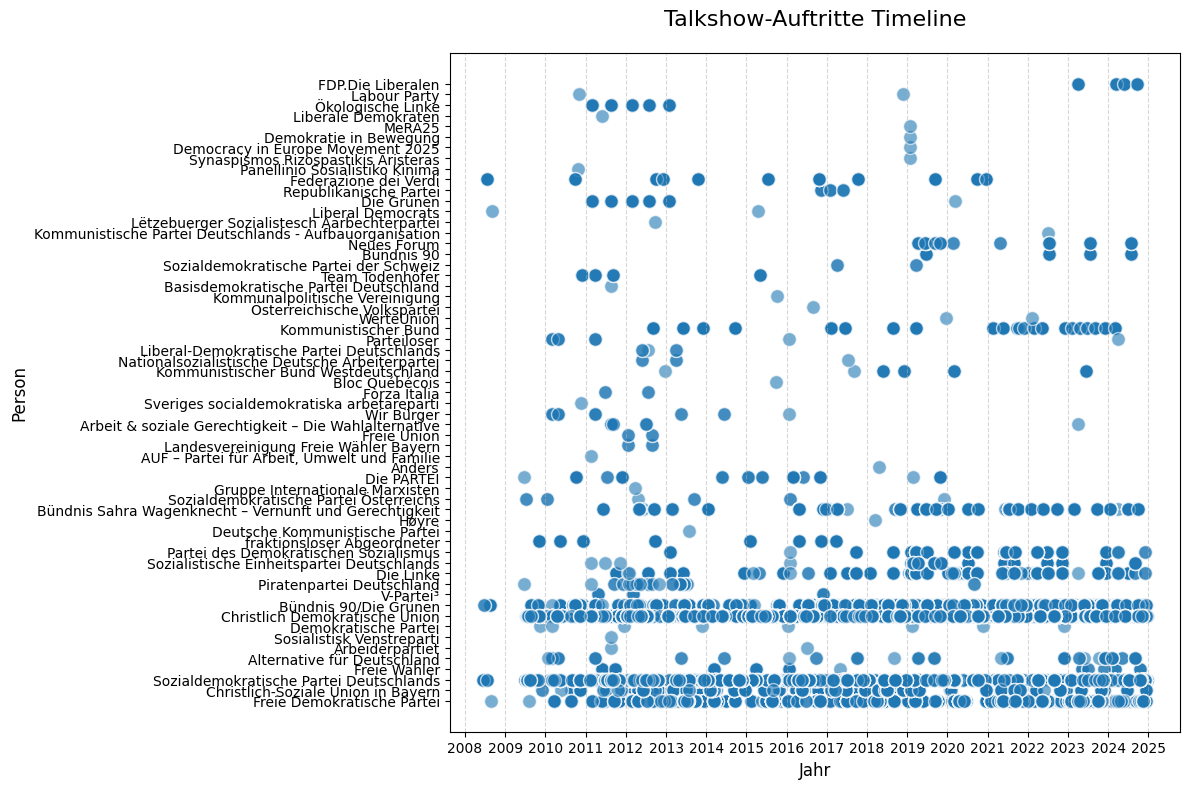

In [16]:
PartyDateDf = pd.read_csv('SPARQL-Results/ParteiAuftritteDatum.csv')
PartyDateDf['date'] = pd.to_datetime(PartyDateDf['date'])

plt.figure(figsize=(12, 8))

plt.scatter(PartyDateDf['date'], PartyDateDf['partyLabel'], alpha=0.6, edgecolors='w', s=100)

ax = plt.gca()

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


plt.title('Talkshow-Auftritte Timeline', fontsize=16, pad=20)
plt.xlabel('Jahr', fontsize=12)
plt.ylabel('Person', fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


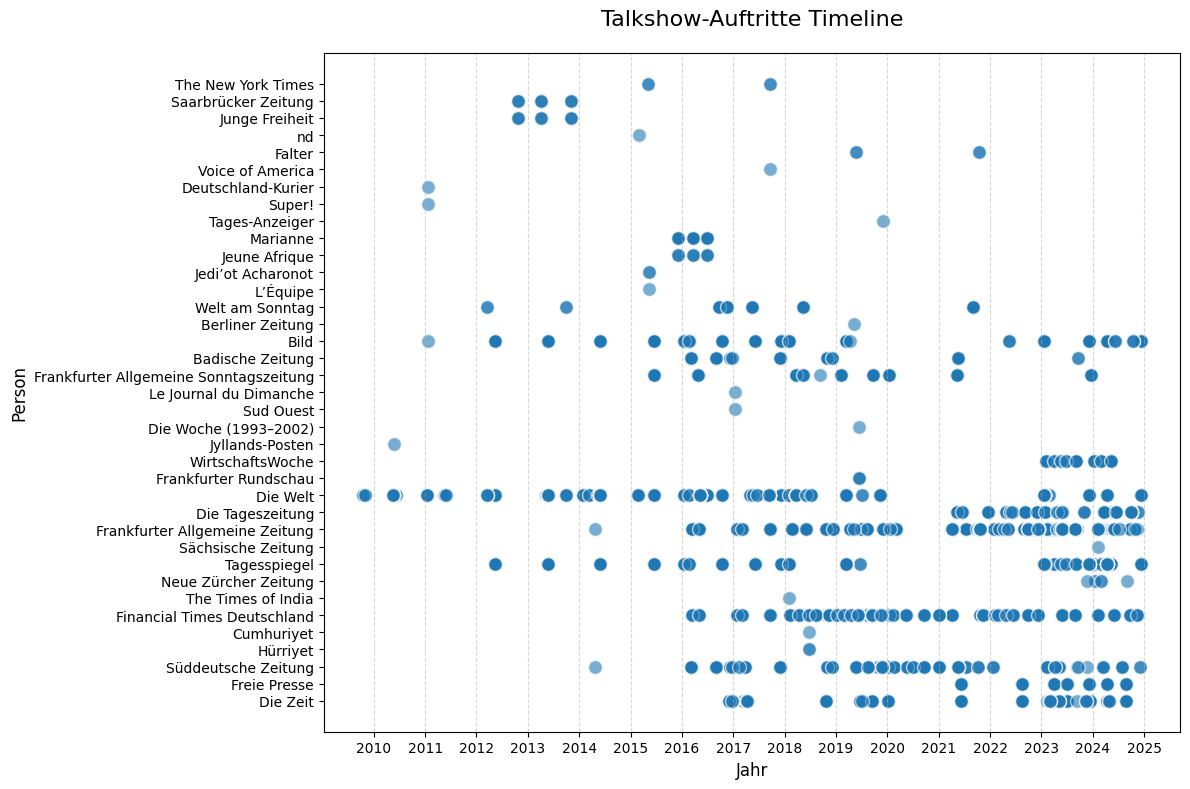

In [17]:
MedienhausDateDf = pd.read_csv('SPARQL-Results/DatumMedienhaus.csv')
MedienhausDateDf['date'] = pd.to_datetime(MedienhausDateDf['date'])

plt.figure(figsize=(12, 8))

plt.scatter(MedienhausDateDf['date'], MedienhausDateDf['employeerLabel'], alpha=0.6, edgecolors='w', s=100)

ax = plt.gca()

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


plt.title('Talkshow-Auftritte Timeline', fontsize=16, pad=20)
plt.xlabel('Jahr', fontsize=12)
plt.ylabel('Person', fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


In [24]:
#Evaluation

#count episodes where not a single guest was found 
df = pd.read_csv('episodes/Episoden.csv')

print(df['Gast_1'].isnull().sum()) 


#Wieviele namen VON
df = pd.read_csv('person/Personen.csv')

print(df['Name'].str.endswith('VON', na=False).sum())

#Count Elmar THEVEßEN in Infos 
df = pd.read_csv('episodes/Episoden.csv')
print(df['Infos'].str.contains("Elmar THEVEßEN", regex=True, na=False).sum())


125
49
83
